In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
data = pd.read_csv('full_data.csv')

In [12]:
data.head()

,P_NAME,P_STATUS,P_MASS,P_MASS_ERROR_MIN,P_MASS_ERROR_MAX,P_RADIUS,P_RADIUS_ERROR_MIN,P_RADIUS_ERROR_MAX,P_YEAR,P_UPDATED,...,P_HABZONE_CON,P_TYPE_TEMP,P_HABITABLE,P_ESI,S_CONSTELLATION,S_CONSTELLATION_ABR,S_CONSTELLATION_ENG,P_RADIUS_EST,P_MASS_EST,P_SEMI_MAJOR_AXIS_EST
0,11 Com b,3.0,6165.86330,-476.74200,476.74200,NaN,NaN,NaN,2007,2014-05-14,...,0,Hot,0,0.083813,Coma Berenices,Com,Berenice's Hair,12.082709,6165.86330,1.29
1,11 UMi b,3.0,4684.78480,-794.57001,794.57001,NaN,NaN,NaN,2009,2018-09-06,...,0,Hot,0,0.082414,Ursa Minor,UMi,Little Bear,12.229641,4684.78480,1.53
2,14 And b,3.0,1525.57440,NaN,NaN,NaN,NaN,NaN,2008,2014-05-14,...,0,Hot,0,0.081917,Andromeda,And,Andromeda,12.848516,1525.57440,0.83
3,14 Her b,3.0,1481.07850,-47.67420,47.67420,NaN,NaN,NaN,2002,2018-09-06,...,0,Cold,0,0.145241,Hercules,Her,Hercules,12.865261,1481.07850,2.93
4,16 Cyg B b,3.0,565.73385,-25.42624,25.42624,NaN,NaN,NaN,1996,2018-09-06,...,1,Warm,0,0.368627,Cygnus,Cyg,Swan,13.421749,565.73385,1.66


In [15]:
#Use only 30 columns

#extract those 30 columns to df

df = data[[
    'P_MASS','P_RADIUS','P_DENSITY','P_GRAVITY','P_ESCAPE','P_TYPE',
    'P_PERIOD','P_SEMI_MAJOR_AXIS','P_ECCENTRICITY','P_INCLINATION',
    'P_OMEGA','P_PERIASTRON','P_APASTRON','P_IMPACT_PARAMETER','P_HILL_SPHERE',
    'S_MASS','S_RADIUS','S_LUMINOSITY','S_TEMPERATURE','S_AGE',
    'S_METALLICITY','S_LOG_G','S_TYPE','S_MAG','S_DISC','S_MAGNETIC_FIELD',
    'S_SNOW_LINE','S_TIDAL_LOCK','P_DETECTION','P_DISTANCE'
]]

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4048 entries, 0 to 4047
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   P_MASS              1598 non-null   float64
 1   P_RADIUS            3139 non-null   float64
 2   P_DENSITY           706 non-null    float64
 3   P_GRAVITY           706 non-null    float64
 4   P_ESCAPE            706 non-null    float64
 5   P_TYPE              4031 non-null   object 
 6   P_PERIOD            3938 non-null   float64
 7   P_SEMI_MAJOR_AXIS   2367 non-null   float64
 8   P_ECCENTRICITY      1380 non-null   float64
 9   P_INCLINATION       844 non-null    float64
 10  P_OMEGA             746 non-null    float64
 11  P_PERIASTRON        3978 non-null   float64
 12  P_APASTRON          3978 non-null   float64
 13  P_IMPACT_PARAMETER  1409 non-null   float64
 14  P_HILL_SPHERE       1546 non-null   float64
 15  S_MASS              3283 non-null   float64
 16  S_RADI

Missing Values over here

In [17]:
#Missing values
df.isnull().sum()



,0
P_MASS,2450
P_RADIUS,909
P_DENSITY,3342
P_GRAVITY,3342
P_ESCAPE,3342
P_TYPE,17
P_PERIOD,110
P_SEMI_MAJOR_AXIS,1681
P_ECCENTRICITY,2668
P_INCLINATION,3204


Summary of missing values

In [18]:
#mathematical_missing_data

missing_summary = pd.DataFrame({
    "Missing Count": df.isnull().sum(),
    "Missing %": (df.isnull().mean() * 100).round(2)
}).sort_values(by="Missing %", ascending=False)

missing_summary


,Missing Count,Missing %
S_MAGNETIC_FIELD,4048,100.00
S_DISC,4048,100.00
P_ESCAPE,3342,82.56
P_DENSITY,3342,82.56
P_GRAVITY,3342,82.56
P_OMEGA,3302,81.57
P_INCLINATION,3204,79.15
S_TYPE,2678,66.16
P_ECCENTRICITY,2668,65.91
P_IMPACT_PARAMETER,2639,65.19


**BarPlot of missing values**

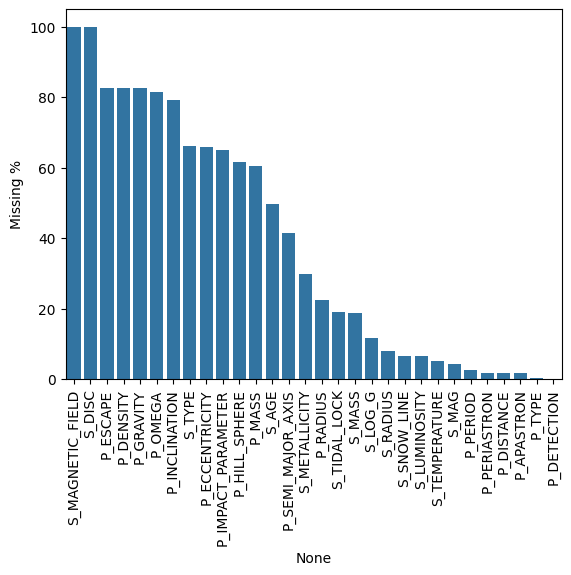

In [26]:
sns.barplot(
    x=missing_summary.index,
    y=missing_summary["Missing %"]
)
plt.xticks(rotation=90)
plt.show()

**MATRIX OF MISSING VALUES**

<Axes: >

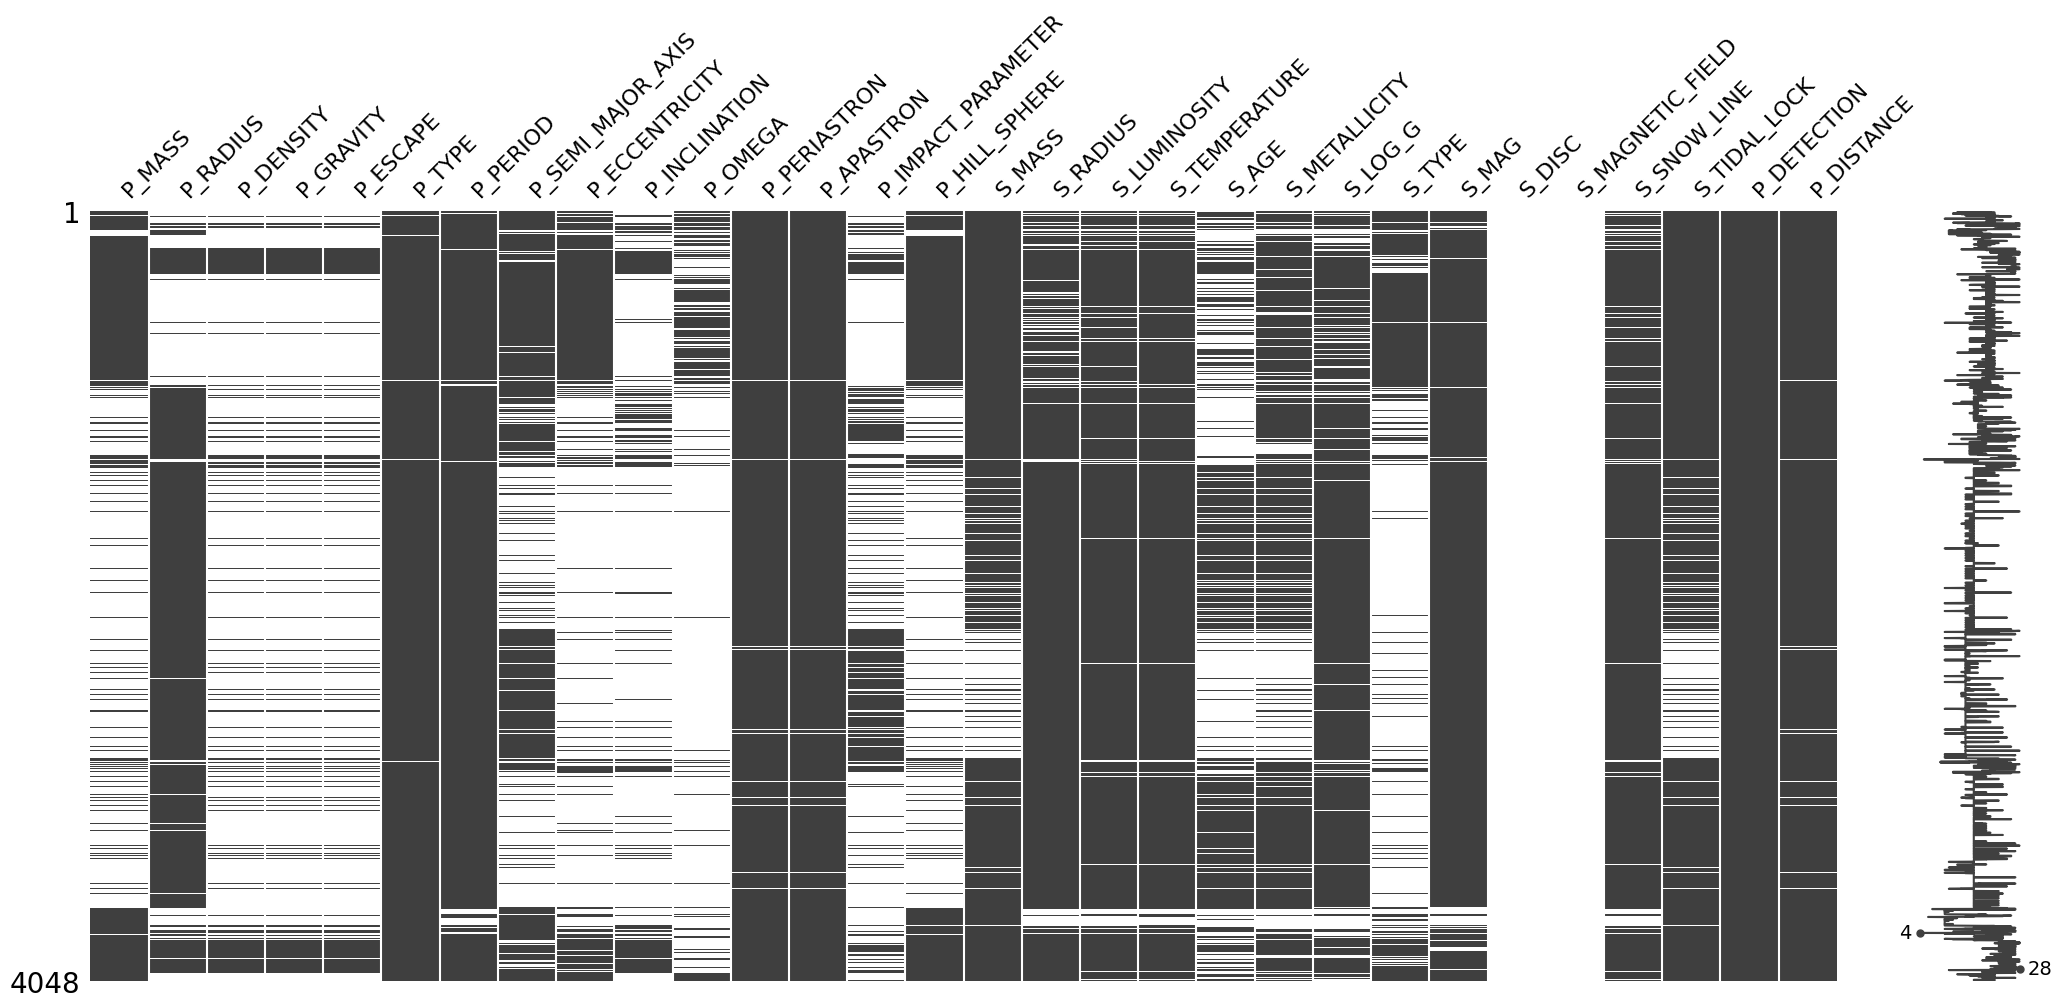

In [27]:
import missingno as msno
msno.matrix(df)

HeatMap

<Axes: >

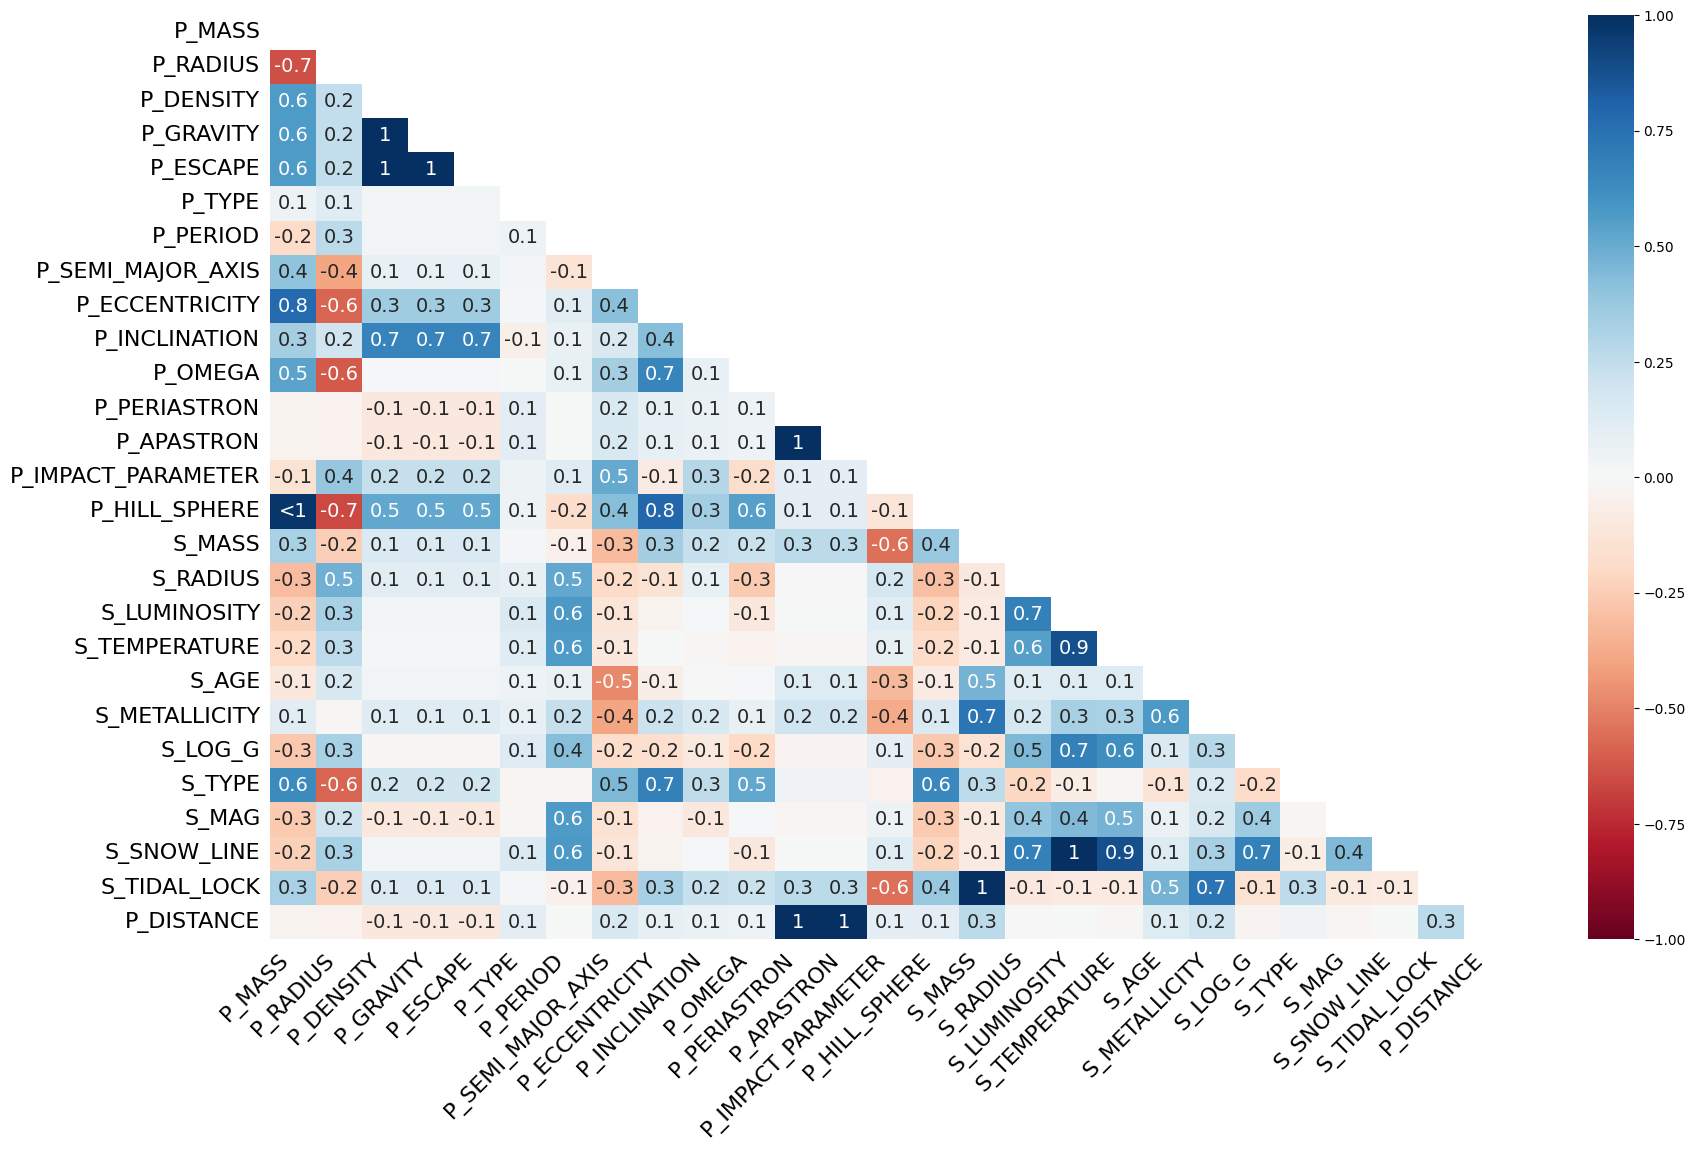

In [28]:
msno.heatmap(df)

**Looking at change in the missing values on changing distance**

In [33]:
dist = df.groupby(pd.qcut(df['P_DISTANCE'],4)).apply(lambda x:x.isnull().mean())

dist

,P_MASS,P_RADIUS,P_DENSITY,P_GRAVITY,P_ESCAPE,P_TYPE,P_PERIOD,P_SEMI_MAJOR_AXIS,P_ECCENTRICITY,P_INCLINATION,...,S_METALLICITY,S_LOG_G,S_TYPE,S_MAG,S_DISC,S_MAGNETIC_FIELD,S_SNOW_LINE,S_TIDAL_LOCK,P_DETECTION,P_DISTANCE
P_DISTANCE,,,,,,,,,,,,,,,,,,,,,
"(0.00341, 0.0531]",0.598995,0.063317,0.662312,0.662312,0.662312,0.000000,0.000000,0.465327,0.631156,0.611055,...,0.206030,0.121608,0.647236,0.045226,1.0,1.0,0.032161,0.112563,0.0,0.0
"(0.0531, 0.103]",0.747495,0.070140,0.816633,0.816633,0.816633,0.001002,0.000000,0.455912,0.776553,0.776553,...,0.299599,0.066132,0.768537,0.024048,1.0,1.0,0.020040,0.237475,0.0,0.0
"(0.103, 0.263]",0.810101,0.098990,0.904040,0.904040,0.904040,0.005051,0.001010,0.486869,0.819192,0.871717,...,0.349495,0.069697,0.825253,0.002020,1.0,1.0,0.037374,0.280808,0.0,0.0
"(0.263, 2500.0]",0.273367,0.675377,0.941709,0.941709,0.941709,0.007035,0.107538,0.212060,0.387940,0.893467,...,0.289447,0.215075,0.394975,0.107538,1.0,1.0,0.168844,0.071357,0.0,0.0


Heat Map

**Y Axis is Distance**

**X Axis is Columns**



<Axes: ylabel='P_DISTANCE'>

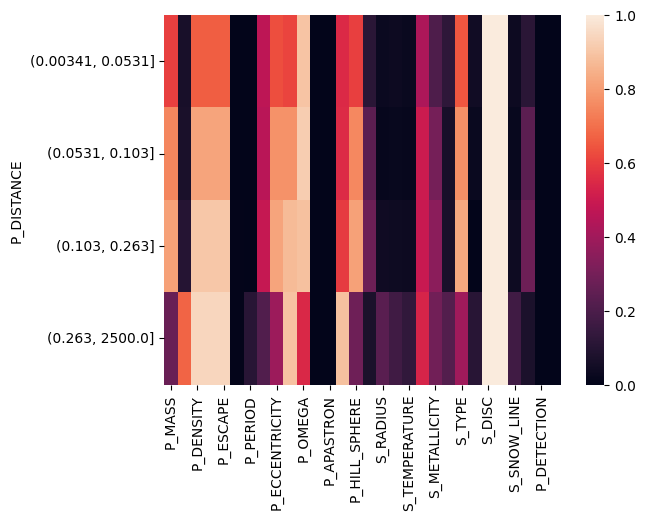

In [32]:
sns.heatmap(dist)

This shows that missing values are structured with distance showing diffculties to caculate parameters

**SUMMARY**


Missingness can be classified in 3 types :- High,Moderate,Low



High




*   S_MAGNETIC_FIELD (100%)
*   S_DISC

*   P_ESCAPE
*   P_DENSITY


*   P_GRAVITY
*   P_OMEGA


*   P_INCLINATION
*   P_TYPE


*   P_ECCENTRICITY
*   P_IMPACT-PARAMETER


*   P_HILL_SPHERE


Moderate



*   P_SEMI_MAJOR_AXIS
*   S_METALLICITY


*   S_AGE
*   P_RADIUS


*   S_TIDAL_LOCK

Low



*   S_MASS
*   S_RADIUS


*   S_LUMINOSITY
*   S_TEMPERATURE


*   S_MAG
*   P_DISTANCE


*   P_DETECTION
*   P_APASTRON


*   P_PERIASTRON












The missing values in the dataset are not randomly distibuted. Features related to orbital mechanics( eg. eccentricity,inclination, impact parameter) and advanced stellar properties(eg magnetic field,disc presence) show consistently high missing data, while basic things  are easy available in this data

This pattern indicates that MNAR (missing not at random) it is due to observational and mehodolgy limitations.And thus missing data is not a random noise.






















